In [1]:
# Pkg.build("Plots") 
using Plots
using Colors

# Set the default plot size to something that fits a cell
default(size = (800, 300))

In [2]:
@enum VegetationType forest field knotweed

mutable struct Cell
    status::VegetationType
    knotweed_age::Int8
end

mutable struct Parameters
    litetime::Int8
    spread_propability::Float32
    spore_rate::Float32
end

parameters = Parameters(8, 0.1, 0.02)

Parameters(8, 0.1f0, 0.02f0)

In [3]:
function create_map(width::Int64=32, height::Int64=32)
    cells = Array{Cell}(undef, width, height)
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]
            cells[i,j] = Cell(field, 0)
        end
    end
    for i in 1:size(cells)[1]
            cells[i,1] = Cell(forest, 0)
    end
    cells[width÷2,height÷2].status = knotweed
    return cells
end

# Map the cells to colors
function to_colors(cell::Cell)
    if cell.status == field
        return RGB(0.0,0.8,0.0)
    end
    if cell.status == knotweed
        return RGB(0.8,0.0,0.0)
    end
    if cell.status == forest
        return RGB(0.3,1.0,0.3)
    end
end

function interact!(new_cell::Cell, other_cell::Cell, parameters::Parameters)
    if new_cell.status == field && other_cell.status == knotweed
        if rand(1)[1] < parameters.spread_propability
            new_cell.status = knotweed
            new_cell.knotweed_age = 0
        end
    end
end

function update!(new_cell::Cell, parameters::Parameters)
    if new_cell.status == knotweed
        new_cell.knotweed_age += 1
        if new_cell.knotweed_age > parameters.litetime
            new_cell.status = field
        end
    end
end

function update(cells::Matrix{Cell}, parameters::Parameters)
    new_cells = deepcopy(cells)
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]
            update!(new_cells[i,j], parameters)
        end
    end
    for i in 1:size(cells)[1]-1
        for j in 1:size(cells)[2]
            interact!(new_cells[i,j], cells[i+1,j], parameters)
            interact!(new_cells[i+1,j], cells[i,j], parameters)
        end
    end
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]-1
            interact!(new_cells[i,j], cells[i,j+1], parameters)
            interact!(new_cells[i,j+1], cells[i,j], parameters)
        end
    end
    return new_cells
end

function count_knotweed(cells::Matrix{Cell})
    infections = 0
    deaths = 0
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]
            if cells[i,j].status == knotweed
                infections += 1
            end
        end
    end
    return infections
end

count_knotweed (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /u/24/rantahj1/unix/src/julia-introduction/notebooks/pandemic.gif
└ @ Plots /u/24/rantahj1/unix/.julia/packages/Plots/YVapH/src/animation.jl:104


Plots.AnimatedGif("/u/24/rantahj1/unix/src/julia-introduction/notebooks/pandemic.gif")
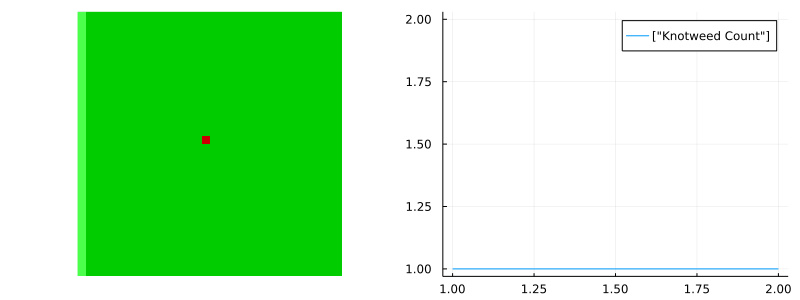

In [4]:
cells = create_map()
count = [count_knotweed(cells)]

anim = @animate for i ∈ 1:200
    cells = update(cells, parameters)
    append!(count, count_knotweed(cells))
    
    l = @layout [a b]
    p1 = plot(to_colors.(cells),legend=false, border=:none)
    p2 = plot([count], label = ["Knotweed Count"])
    frame = plot(p1, p2, layout = l)
    frame
end
gif(anim, "pandemic.gif", fps = 5)